 ## Here are the tests for the different detectors

In [1]:
# Import necessary dependencies
import cv2
import numpy as np
import sys
import os
import matplotlib.pyplot as plt
import torch
from PIL import Image

# Import Ikomia API
from ikomia.dataprocess.workflow import Workflow
from ikomia.dataprocess import CImageIO, CInstanceSegmentationIO
from ikomia.core import CWorkflowTaskIO, IODataType

# Import the custom modules
from simple_lama_inpainting import SimpleLama
# from diffusers import StableDiffusionInpaintPipeline
# import transformers

# Import the necessary classes
from detectors import RedCapDetector 
from detectors import YOLODetector
from segmentors import YoloSegmentor
from removers import BlurringRemover
from removers import LamaInpaintingRemover

# interactive notebook widgets
import ipywidgets as widgets
from ipywidgets import interact, interact_manual

In [2]:
%matplotlib inline

In [3]:
def imshow(image, cmap=None):
  image_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
  plt.imshow(image_rgb, cmap)
  plt.axis('off')  # Hide axis for better visualization
  plt.show()

In [4]:

YoloDetector = YOLODetector(device='cuda')
segmentor = YoloSegmentor(device='cuda')

/users/eleves-b/2022/mathias.perez/Desktop/INF573-MakeBenardDisappear/ikomia_env/lib64/python3.9/site-packages/numpy/core/getlimits.py:500: UserWarning: The value of the smallest subnormal for <class 'numpy.float64'> type is zero.
  setattr(self, word, getattr(machar, word).flat[0])
/users/eleves-b/2022/mathias.perez/Desktop/INF573-MakeBenardDisappear/ikomia_env/lib64/python3.9/site-packages/numpy/core/getlimits.py:89: UserWarning: The value of the smallest subnormal for <class 'numpy.float64'> type is zero.
  return self._float_to_str(self.smallest_subnormal)
/users/eleves-b/2022/mathias.perez/Desktop/INF573-MakeBenardDisappear/ikomia_env/lib64/python3.9/site-packages/numpy/core/getlimits.py:500: UserWarning: The value of the smallest subnormal for <class 'numpy.float32'> type is zero.
  setattr(self, word, getattr(machar, word).flat[0])
/users/eleves-b/2022/mathias.perez/Desktop/INF573-MakeBenardDisappear/ikomia_env/lib64/python3.9/site-packages/numpy/core/getlimits.py:89: UserWarnin

WARNING ⚠️ Python>=3.10 is required, but Python==3.9.18 is currently installed 


In [5]:
test_image = cv2.imread('_test_data/test1.jpg')
imshow(test_image)

In [6]:
"""
Test if the red cap detector correctly identifies a bounding box for a red cap.
"""
red_cap_detector = RedCapDetector()

red_cap_boxes = red_cap_detector.detect(test_image)
print("Red Cap Detector Output:", red_cap_boxes)
# Draw the bounding box on the image knowing that the red_cap_detector returns a bounding box in the form (x, y, w, h) where the red cap is located. If no cap is found, returns None.

if red_cap_boxes is not None:
    test_image_bis = test_image.copy()
    for box in red_cap_boxes:
        x, y, w, h = box
        cv2.rectangle(test_image_bis, (x, y), (x+w, y+h), (0, 255, 0), 2)
        # cv2.putText(test_image_bis, 'Red Cap', (x, y-10), cv2.FONT_HERSHEY_SIMPLEX, 0.9, (0, 255, 0), 2)
    
    imshow(test_image_bis)

Red Cap Detector Output: [(424, 451, 83, 49)]


In [7]:
boxes = YoloDetector.human_detect(test_image)

print("YOLO Detector Output:", boxes)

Will run on cuda
Fusing layers... 


/users/eleves-b/2022/mathias.perez/Desktop/INF573-MakeBenardDisappear/ikomia_env/lib64/python3.9/site-packages/torch/functional.py:534: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at ../aten/src/ATen/native/TensorShape.cpp:3595.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]


Workflow Untitled run successfully in 793.085253 ms.
YOLO Detector Output: [(498, 759, 161, 264), (672, 729, 156, 294), (0, 797, 126, 226), (416, 451, 119, 474), (611, 506, 111, 452), (222, 796, 162, 227), (841, 813, 179, 210), (773, 513, 151, 486), (295, 422, 84, 372), (93, 456, 102, 460), (185, 594, 129, 420), (491, 344, 92, 368), (696, 394, 88, 372), (862, 437, 104, 347)]


In [8]:
%%time
"""
Test if the human detector correctly identifies a bounding box for a person.
"""

human_boxes = YoloDetector.detect(test_image)
mask = segmentor.segment(test_image, human_boxes)

imshow(mask, cmap='gray')

print(type(mask))
print(mask.shape)

Workflow Untitled run successfully in 32.566348 ms.



0: 640x640 1 person, 21.2ms
Speed: 2.3ms preprocess, 21.2ms inference, 2.8ms postprocess per image at shape (1, 3, 640, 640)
Workflow Untitled run successfully in 456.125192 ms.
<class 'numpy.ndarray'>
(1024, 1024)
CPU times: user 647 ms, sys: 115 ms, total: 762 ms
Wall time: 509 ms


In [13]:
from modelscope.outputs import OutputKeys
from modelscope.pipelines import pipeline
from modelscope.utils.constant import Tasks

inpainting = pipeline(Tasks.image_inpainting, model='damo/cv_fft_inpainting_lama', refine=True)

2024-11-03 15:14:38,033 - modelscope - WARNING - Model revision not specified, use revision: v1.0.0
/users/eleves-b/2022/mathias.perez/Desktop/INF573-MakeBenardDisappear/ikomia_env/lib64/python3.9/site-packages/kornia/feature/lightglue.py:44: FutureWarning: `torch.cuda.amp.custom_fwd(args...)` is deprecated. Please use `torch.amp.custom_fwd(args..., device_type='cuda')` instead.
  @torch.cuda.amp.custom_fwd(cast_inputs=torch.float32)
2024-11-03 15:14:39,036 - modelscope - INFO - initiate model from /users/eleves-b/2022/mathias.perez/.cache/modelscope/hub/damo/cv_fft_inpainting_lama
2024-11-03 15:14:39,036 - modelscope - INFO - initiate model from location /users/eleves-b/2022/mathias.perez/.cache/modelscope/hub/damo/cv_fft_inpainting_lama.
2024-11-03 15:14:39,038 - modelscope - INFO - initialize model from /users/eleves-b/2022/mathias.perez/.cache/modelscope/hub/damo/cv_fft_inpainting_lama
2024-11-03 15:14:39,049 - modelscope - INFO - BaseInpaintingTrainingModule init called, predict_o

Loading weights for net_encoder


2024-11-03 15:14:40,341 - modelscope - INFO - BaseInpaintingTrainingModule init done
2024-11-03 15:14:40,342 - modelscope - INFO - loading pretrained model from /users/eleves-b/2022/mathias.perez/.cache/modelscope/hub/damo/cv_fft_inpainting_lama/pytorch_model.pt
2024-11-03 15:14:44,030 - modelscope - WARNING - No preprocessor field found in cfg.
2024-11-03 15:14:44,031 - modelscope - WARNING - No val key and type key found in preprocessor domain of configuration.json file.
2024-11-03 15:14:44,031 - modelscope - WARNING - Cannot find available config to build preprocessor at mode inference, current config: {'model_dir': '/users/eleves-b/2022/mathias.perez/.cache/modelscope/hub/damo/cv_fft_inpainting_lama'}. trying to build by task and model information.
2024-11-03 15:14:44,031 - modelscope - WARNING - No preprocessor key ('FFTInpainting', 'image-inpainting') found in PREPROCESSOR_MAP, skip building preprocessor.
2024-11-03 15:14:44,032 - modelscope - INFO - loading model from dir /users

In [14]:
help(inpainting)

Help on ImageInpaintingPipeline in module modelscope.pipelines.cv.image_inpainting_pipeline object:

class ImageInpaintingPipeline(modelscope.pipelines.base.Pipeline)
 |  ImageInpaintingPipeline(model: str, pad_out_to_modulo=8, refine=False, **kwargs)
 |  
 |  Method resolution order:
 |      ImageInpaintingPipeline
 |      modelscope.pipelines.base.Pipeline
 |      abc.ABC
 |      builtins.object
 |  
 |  Methods defined here:
 |  
 |  __init__(self, model: str, pad_out_to_modulo=8, refine=False, **kwargs)
 |      model: model id on modelscope hub.
 |  
 |  ceil_modulo(self, x, mod)
 |  
 |  forward(self, input: Dict[str, Any]) -> Dict[str, Any]
 |      Provide default implementation using self.model and user can reimplement it
 |  
 |  move_to_device(self, obj, device)
 |  
 |  pad_img_to_modulo(self, img, mod)
 |  
 |  perform_inference(self, data)
 |  
 |  postprocess(self, inputs: Dict[str, Any]) -> Dict[str, Any]
 |      If current pipeline support model reuse, common postprocess

In [16]:
print(type(test_image))
print(type(mask))

<class 'numpy.ndarray'>
<class 'numpy.ndarray'>


In [17]:


input_image = Image.fromarray(test_image)
input_mask = Image.fromarray(mask)
input = {
        'img':input_image,
        'mask':input_mask
}

result = inpainting(input)
vis_img = result[OutputKeys.OUTPUT_IMG]
vis_img = cv2.cvtColor(np.array(vis_img), cv2.COLOR_RGB2BGR)
cv2.imwrite('result.png', vis_img)

Original image too large for refinement! Resizing (1024, 1024) to (948, 948)...


True

In [18]:
vis_img = cv2.cvtColor(np.array(vis_img), cv2.COLOR_RGB2BGR)
cv2.imwrite('result.png', vis_img)

True

In [ ]:
simple_lama = SimpleLama()

help(simple_lama)

Downloading: "https://github.com/enesmsahin/simple-lama-inpainting/releases/download/v0.1.0/big-lama.pt" to /users/eleves-b/2022/mathias.perez/.cache/torch/hub/checkpoints/big-lama.pt
100%|██████████| 196M/196M [00:28<00:00, 7.34MB/s] 


Help on SimpleLama in module simple_lama_inpainting.models.model object:

class SimpleLama(builtins.object)
 |  SimpleLama(device=device(type='cuda')) -> None
 |  
 |  Methods defined here:
 |  
 |  __call__(self, image, mask)
 |      Call self as a function.
 |  
 |  __init__(self, device=device(type='cuda')) -> None
 |      Initialize self.  See help(type(self)) for accurate signature.
 |  
 |  ----------------------------------------------------------------------
 |  Data descriptors defined here:
 |  
 |  __dict__
 |      dictionary for instance variables (if defined)
 |  
 |  __weakref__
 |      list of weak references to the object (if defined)



In [ ]:
result = simple_lama(test_image, mask)


<class 'PIL.Image.Image'>
<class 'numpy.ndarray'>
(1024, 1024, 3)


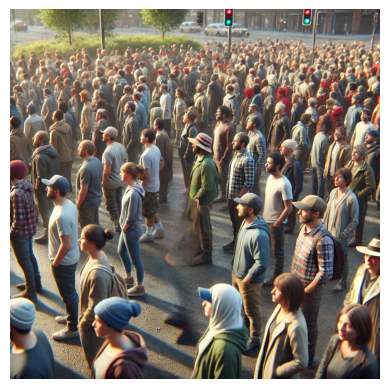

In [ ]:
print(type(result))
image_array = np.array(result)
print(type(image_array))
print(image_array.shape)

imshow(image_array)

In [ ]:
image_rgb = cv2.cvtColor(test_image, cv2.COLOR_BGR2RGB)


# Convert the numpy arrays to PIL Images
image_pil = Image.fromarray(image_rgb)
mask_pil = Image.fromarray(mask).convert("L")  # Ensure the mask is single-channel (grayscale)

# Load the pre-trained inpainting pipeline
pipe = StableDiffusionInpaintPipeline.from_pretrained("runwayml/stable-diffusion-inpainting")
pipe.to("cuda" if torch.cuda.is_available() else "cpu")

# Run the inpainting model
prompt = "nothing"
result = pipe(prompt=prompt, image=image_pil, mask_image=mask_pil).images[0]

# Display or save the result
result.show()  # To show the image directly
result.save("inpainted_result.jpg")  # To save the output to a file

Loading pipeline components...:   0%|          | 0/7 [00:00<?, ?it/s]

An error occurred while trying to fetch /users/eleves-b/2022/mathias.perez/.cache/huggingface/hub/models--runwayml--stable-diffusion-inpainting/snapshots/8a4288a76071f7280aedbdb3253bdb9e9d5d84bb/unet: Error no file named diffusion_pytorch_model.safetensors found in directory /users/eleves-b/2022/mathias.perez/.cache/huggingface/hub/models--runwayml--stable-diffusion-inpainting/snapshots/8a4288a76071f7280aedbdb3253bdb9e9d5d84bb/unet.
Defaulting to unsafe serialization. Pass `allow_pickle=False` to raise an error instead.
An error occurred while trying to fetch /users/eleves-b/2022/mathias.perez/.cache/huggingface/hub/models--runwayml--stable-diffusion-inpainting/snapshots/8a4288a76071f7280aedbdb3253bdb9e9d5d84bb/vae: Error no file named diffusion_pytorch_model.safetensors found in directory /users/eleves-b/2022/mathias.perez/.cache/huggingface/hub/models--runwayml--stable-diffusion-inpainting/snapshots/8a4288a76071f7280aedbdb3253bdb9e9d5d84bb/vae.
Defaulting to unsafe serialization. Pas

  0%|          | 0/50 [00:00<?, ?it/s]

In [ ]:
inpainted = result.
imshow(inpainted)

AttributeError: 'Image' object has no attribute 'numpy'

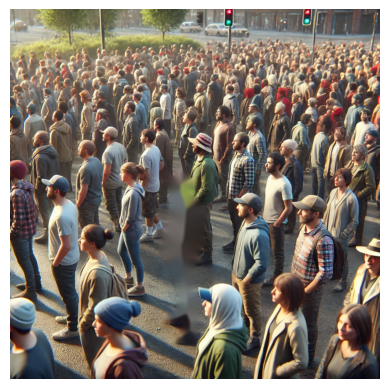

In [ ]:
OpencvRemover = InpaintingRemover(inpaint_radius=10)

# Apply the inpainting algorithm to remove the human from the image



output = OpencvRemover.remove(test_image, mask)
imshow(output)

In [ ]:
test_image1 = cv2.imread('_test_data/test1.jpg') 
test_image2 = cv2.imread('_test_data/test2.jpg')
test_image3 = cv2.imread('_test_data/test3.jpg')
test_image4 = cv2.imread('_test_data/test4.jpg')

images = [test_image1, test_image2, test_image3, test_image4]

Workflow Untitled run successfully in 32.758547 ms.

0: 640x640 1 person, 20.3ms
Speed: 0.8ms preprocess, 20.3ms inference, 1.7ms postprocess per image at shape (1, 3, 640, 640)
Workflow Untitled run successfully in 302.655128 ms.


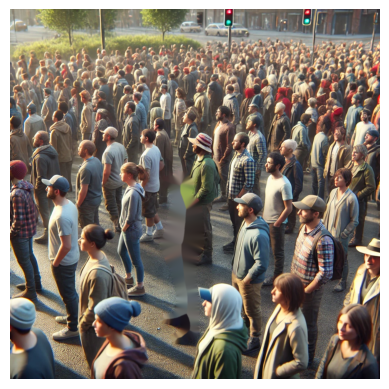

Workflow Untitled run successfully in 32.297614 ms.

0: 640x640 2 persons, 1 cup, 21.0ms
Speed: 0.8ms preprocess, 21.0ms inference, 1.7ms postprocess per image at shape (1, 3, 640, 640)
Workflow Untitled run successfully in 308.343699 ms.


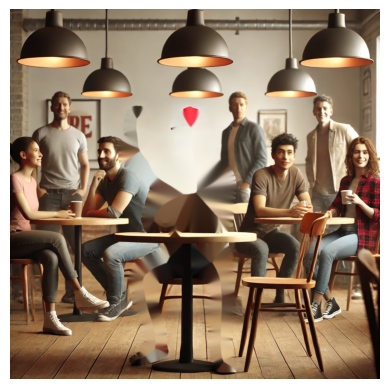

Workflow Untitled run successfully in 34.579467 ms.

0: 640x640 3 persons, 1 chair, 20.4ms
Speed: 0.8ms preprocess, 20.4ms inference, 1.7ms postprocess per image at shape (1, 3, 640, 640)
Workflow Untitled run successfully in 308.294758 ms.


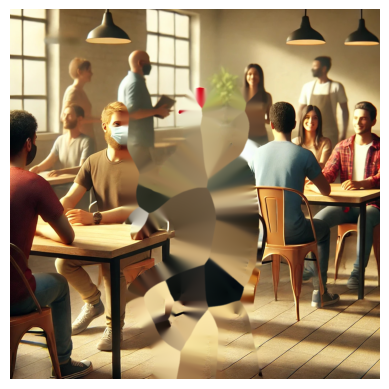

Workflow Untitled run successfully in 33.004788 ms.

0: 640x640 1 person, 20.5ms
Speed: 0.8ms preprocess, 20.5ms inference, 1.6ms postprocess per image at shape (1, 3, 640, 640)
Workflow Untitled run successfully in 301.88591 ms.


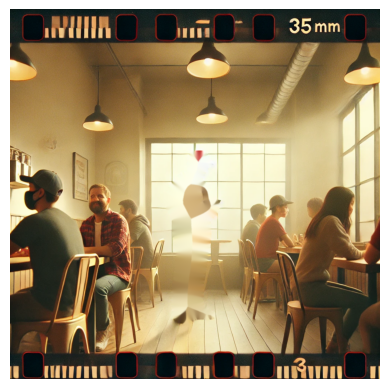

In [ ]:
for image in images:
    boxes = YoloDetector.detect(image)
    mask = segmentor.segment(image, boxes)

    output = OpencvRemover.remove(image, mask)
    imshow(output)

In [ ]:
segmentor = YoloSegmentor(device='cuda')


0: 640x640 1 person, 20.4ms
Speed: 0.8ms preprocess, 20.4ms inference, 1.7ms postprocess per image at shape (1, 3, 640, 640)
Workflow Untitled run successfully in 303.541264 ms.


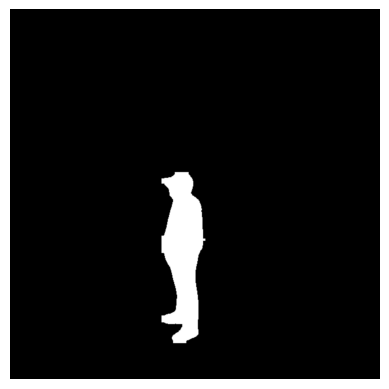

In [ ]:
mask = segmentor.segment(test_image, human_boxes)

imshow(mask, cmap='gray')

In [ ]:
remover = BlurringRemover(blur_kernel_size=(71, 71))

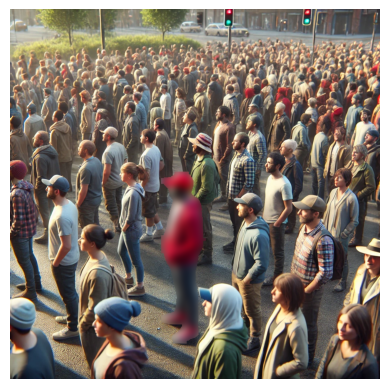

In [ ]:
blurred_image = remover.remove(test_image, mask)

imshow(blurred_image)

In [ ]:
# Add the Canny Edge Detector
segmentor = wf.add_task(name="infer_yolo_v8_seg", auto_connect=True)

# Run on your image
test_image_bounded = test_image.copy()
for box in intersections:
    x, y, w, h = box
    # Fill everything outside the bounding box with black
    test_image_bounded[:y, :] = 0
    test_image_bounded[y+h:, :] = 0
    test_image_bounded[:, :x] = 0
    test_image_bounded[:, x+w:] = 0

imshow(test_image_bounded)

wf.run_on(test_image_bounded)

imshow(segmentor.get_image_with_mask_and_graphics())

NameError: name 'wf' is not defined

In [ ]:
results = segmentor.get_results()
print(test_image_bounded.shape)

for obj in results.get_objects():
    print(obj.mask)
    print(obj.mask.shape)



(1024, 1024, 3)
[[0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 ...
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]]
(1024, 1024)


In [ ]:
# Let's test the find intersecting human function for all test cases
test_image1 = cv2.imread('_test_data/test1.jpg') 
test_image2 = cv2.imread('_test_data/test2.jpg')
test_image3 = cv2.imread('_test_data/test3.jpg')
test_image4 = cv2.imread('_test_data/test4.jpg')

human_detector = YOLODetector(device='cuda')

red_cap_boxes_1 = red_cap_detector.detect(test_image1,hue_range=(0, 5), alt_hue_range=(170, 180))
red_cap_boxes_2 = red_cap_detector.detect(test_image2,hue_range=(0, 5), alt_hue_range=(170, 180))
red_cap_boxes_3 = red_cap_detector.detect(test_image3, hue_range=(0, 5), alt_hue_range=(170, 180))
red_cap_boxes_4 = red_cap_detector.detect(test_image4,hue_range=(0, 5), alt_hue_range=(170, 180))

human_boxes_1 = human_detector.detect(test_image1)
human_boxes_2 = human_detector.detect(test_image2)
human_boxes_3 = human_detector.detect(test_image3)
human_boxes_4 = human_detector.detect(test_image4)

intersections_1 = find_intersecting_human(red_cap_boxes_1, human_boxes_1)
intersections_2 = find_intersecting_human(red_cap_boxes_2, human_boxes_2)
intersections_3 = find_intersecting_human(red_cap_boxes_3, human_boxes_3)
intersections_4 = find_intersecting_human(red_cap_boxes_4, human_boxes_4)

if intersections_1 is not None:
    test_image_bis1 = test_image1.copy()
    for box in intersections_1:
        x, y, w, h = box
        cv2.rectangle(test_image_bis1, (x, y), (x+w, y+h), (0, 255, 0), 2)

if intersections_2 is not None:
    test_image_bis2 = test_image2.copy()
    for box in intersections_2:
        x, y, w, h = box
        cv2.rectangle(test_image_bis2, (x, y), (x+w, y+h), (0, 255, 0), 2)

if intersections_3 is not None:
    test_image_bis3 = test_image3.copy()
    for box in intersections_3:
        x, y, w, h = box
        cv2.rectangle(test_image_bis3, (x, y), (x+w, y+h), (0, 255, 0), 2)

if intersections_4 is not None:
    test_image_bis4 = test_image4.copy()
    for box in intersections_4:
        x, y, w, h = box
        cv2.rectangle(test_image_bis4, (x, y), (x+w, y+h), (0, 255, 0), 2)
    
    
    # Display the images in a single plot
fig, axs = plt.subplots(2, 2, figsize=(10, 10))
axs[0, 0].imshow(cv2.cvtColor(test_image_bis1, cv2.COLOR_BGR2RGB))
axs[0, 0].axis('off')
axs[0, 0].set_title('Test Image 1')

axs[0, 1].imshow(cv2.cvtColor(test_image_bis2, cv2.COLOR_BGR2RGB))
axs[0, 1].axis('off')
axs[0, 1].set_title('Test Image 2')

axs[1, 0].imshow(cv2.cvtColor(test_image_bis3, cv2.COLOR_BGR2RGB))
axs[1, 0].axis('off')
axs[1, 0].set_title('Test Image 3')

axs[1, 1].imshow(cv2.cvtColor(test_image_bis4, cv2.COLOR_BGR2RGB))
axs[1, 1].axis('off')
axs[1, 1].set_title('Test Image 4')

plt.show()




Will run on cuda
Fusing layers... 
Workflow Untitled run successfully in 280.321139 ms.
Workflow Untitled run successfully in 31.879235 ms.
Workflow Untitled run successfully in 31.935089 ms.
Workflow Untitled run successfully in 31.494047 ms.



## Let's have more testing for the red cap detector by playing with the multiple parameters it has

In [ ]:
test_image1 = cv2.imread('_test_data/test1.jpg') 
test_image2 = cv2.imread('_test_data/test2.jpg')
test_image3 = cv2.imread('_test_data/test3.jpg')
test_image4 = cv2.imread('_test_data/test4.jpg')

In [ ]:
@interact(min_size = (0, 1000, 10), min_circularity = (0, 1, 0.1))
def imshow_with_red_cap(min_size, min_circularity):
    red_cap_boxes_1 = red_cap_detector.detect(test_image1,hue_range=(0, 5), alt_hue_range=(170, 180), min_size=min_size, min_circularity=min_circularity)
    red_cap_boxes_2 = red_cap_detector.detect(test_image2,hue_range=(0, 5), alt_hue_range=(170, 180), min_size=min_size, min_circularity=min_circularity)
    red_cap_boxes_3 = red_cap_detector.detect(test_image3, hue_range=(0, 5), alt_hue_range=(170, 180),min_size=min_size, min_circularity=min_circularity)
    red_cap_boxes_4 = red_cap_detector.detect(test_image4,hue_range=(0, 5), alt_hue_range=(170, 180), min_size=min_size, min_circularity=min_circularity)

    if red_cap_boxes_1 is not None:
        test_image_bis1 = test_image1.copy()
        for box in red_cap_boxes_1:
            x, y, w, h = box
            cv2.rectangle(test_image_bis1, (x, y), (x+w, y+h), (0, 255, 0), 2)
    
    if red_cap_boxes_2 is not None:
        test_image_bis2 = test_image2.copy()
        for box in red_cap_boxes_2:
            x, y, w, h = box
            cv2.rectangle(test_image_bis2, (x, y), (x+w, y+h), (0, 255, 0), 2)
    
    if red_cap_boxes_3 is not None:
        test_image_bis3 = test_image3.copy()
        for box in red_cap_boxes_3:
            x, y, w, h = box
            cv2.rectangle(test_image_bis3, (x, y), (x+w, y+h), (0, 255, 0), 2)
    
    if red_cap_boxes_4 is not None:
        test_image_bis4 = test_image4.copy()
        for box in red_cap_boxes_4:
            x, y, w, h = box
            cv2.rectangle(test_image_bis4, (x, y), (x+w, y+h), (0, 255, 0), 2)
    
    
    # Display the images in a single plot
    fig, axs = plt.subplots(2, 2, figsize=(10, 10))
    axs[0, 0].imshow(cv2.cvtColor(test_image_bis1, cv2.COLOR_BGR2RGB))
    axs[0, 0].axis('off')
    axs[0, 0].set_title('Test Image 1')

    axs[0, 1].imshow(cv2.cvtColor(test_image_bis2, cv2.COLOR_BGR2RGB))
    axs[0, 1].axis('off')
    axs[0, 1].set_title('Test Image 2')

    axs[1, 0].imshow(cv2.cvtColor(test_image_bis3, cv2.COLOR_BGR2RGB))
    axs[1, 0].axis('off')
    axs[1, 0].set_title('Test Image 3')

    axs[1, 1].imshow(cv2.cvtColor(test_image_bis4, cv2.COLOR_BGR2RGB))
    axs[1, 1].axis('off')
    axs[1, 1].set_title('Test Image 4')

    plt.show()

# Results :
# Circularity needs to be at max 0.3
# Min size at 620 detects the caps only

interactive(children=(IntSlider(value=500, description='min_size', max=1000, step=10), FloatSlider(value=0.0, …

## Lets do the same thing for the human detector now

In [ ]:
@interact(conf = (0, 1, 0.1), iou = (0, 1, 0.1))
def imshow_with_yolo(conf, iou):
    human_boxes_1 = human_detector.detect(test_image1, conf, iou)
    human_boxes_2 = human_detector.detect(test_image2, conf, iou)
    human_boxes_3 = human_detector.detect(test_image3, conf, iou)
    human_boxes_4 = human_detector.detect(test_image4, conf, iou)


    if human_boxes_1 is not None:
        test_image_bis1 = test_image1.copy()
        for box in human_boxes_1:
            x, y, w, h = box
            cv2.rectangle(test_image_bis1, (x, y), (x+w, y+h), (0, 255, 0), 2)
    
    if human_boxes_2 is not None:
        test_image_bis2 = test_image2.copy()
        for box in human_boxes_2:
            x, y, w, h = box
            cv2.rectangle(test_image_bis2, (x, y), (x+w, y+h), (0, 255, 0), 2)

    if human_boxes_3 is not None:
        test_image_bis3 = test_image3.copy()
        for box in human_boxes_3:
            x, y, w, h = box
            cv2.rectangle(test_image_bis3, (x, y), (x+w, y+h), (0, 255, 0), 2)

    if human_boxes_4 is not None:
        test_image_bis4 = test_image4.copy()
        for box in human_boxes_4:
            x, y, w, h = box
            cv2.rectangle(test_image_bis4, (x, y), (x+w, y+h), (0, 255, 0), 2)
    
    
    # Display the images in a single plot
    fig, axs = plt.subplots(2, 2, figsize=(10, 10))
    axs[0, 0].imshow(cv2.cvtColor(test_image_bis1, cv2.COLOR_BGR2RGB))
    axs[0, 0].axis('off')
    axs[0, 0].set_title('Test Image 1')

    axs[0, 1].imshow(cv2.cvtColor(test_image_bis2, cv2.COLOR_BGR2RGB))
    axs[0, 1].axis('off')
    axs[0, 1].set_title('Test Image 2')

    axs[1, 0].imshow(cv2.cvtColor(test_image_bis3, cv2.COLOR_BGR2RGB))
    axs[1, 0].axis('off')
    axs[1, 0].set_title('Test Image 3')

    axs[1, 1].imshow(cv2.cvtColor(test_image_bis4, cv2.COLOR_BGR2RGB))
    axs[1, 1].axis('off')
    axs[1, 1].set_title('Test Image 4')

    plt.show()

# Results :
# Conf needs to be at 0.5
# IOU needs to be at 0.5

interactive(children=(FloatSlider(value=0.0, description='conf', max=1.0), FloatSlider(value=0.0, description=…